In [1]:
# Import required packages
import torch
import numpy as np
import normflows as nf

from sklearn.datasets import make_moons

from matplotlib import pyplot as plt

from tqdm import tqdm

In [ ]:
# Set up model

# Define flows
K = 16
torch.manual_seed(0)

latent_size = 2
hidden_units = 128
hidden_layers = 2

flows = []
for i in range(K):
    flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units)]
    flows += [nf.flows.LULinearPermute(latent_size)]

# Set base distribuiton
q0 = nf.distributions.DiagGaussian(2, trainable=False)

# Construct flow model
nfm = nf.NormalizingFlow(q0=q0, flows=flows)

# Move model on GPU if available
enable_cuda = False
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
nfm = nfm.to(device)

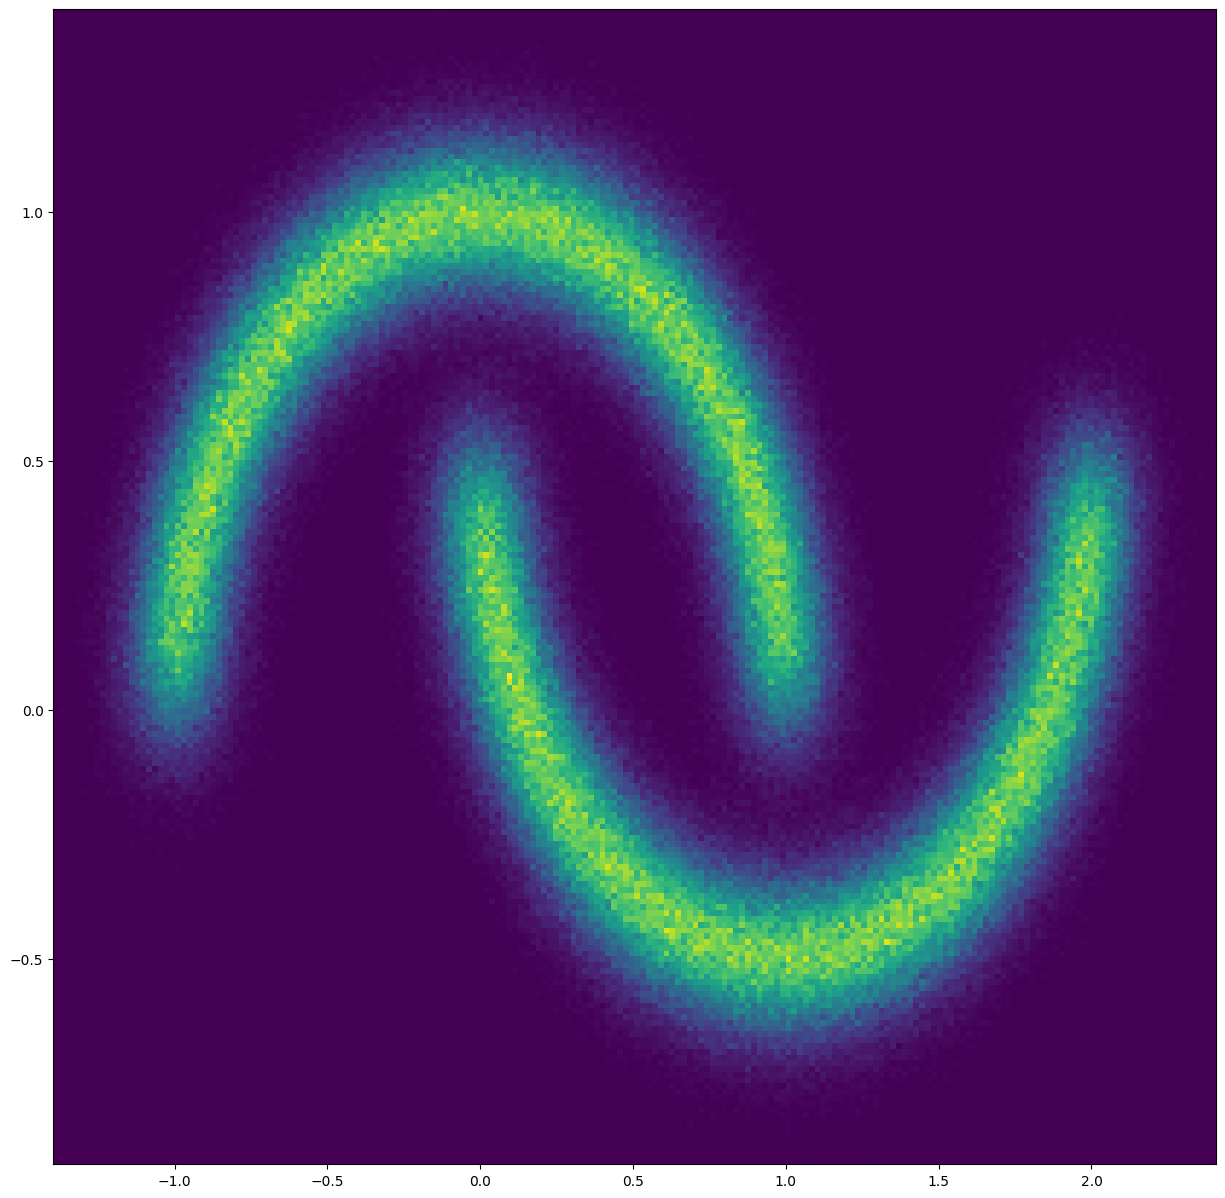

/Users/arvandkaveh/Projects/kit/graph_hdc/.venv/lib/python3.13/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:4316.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


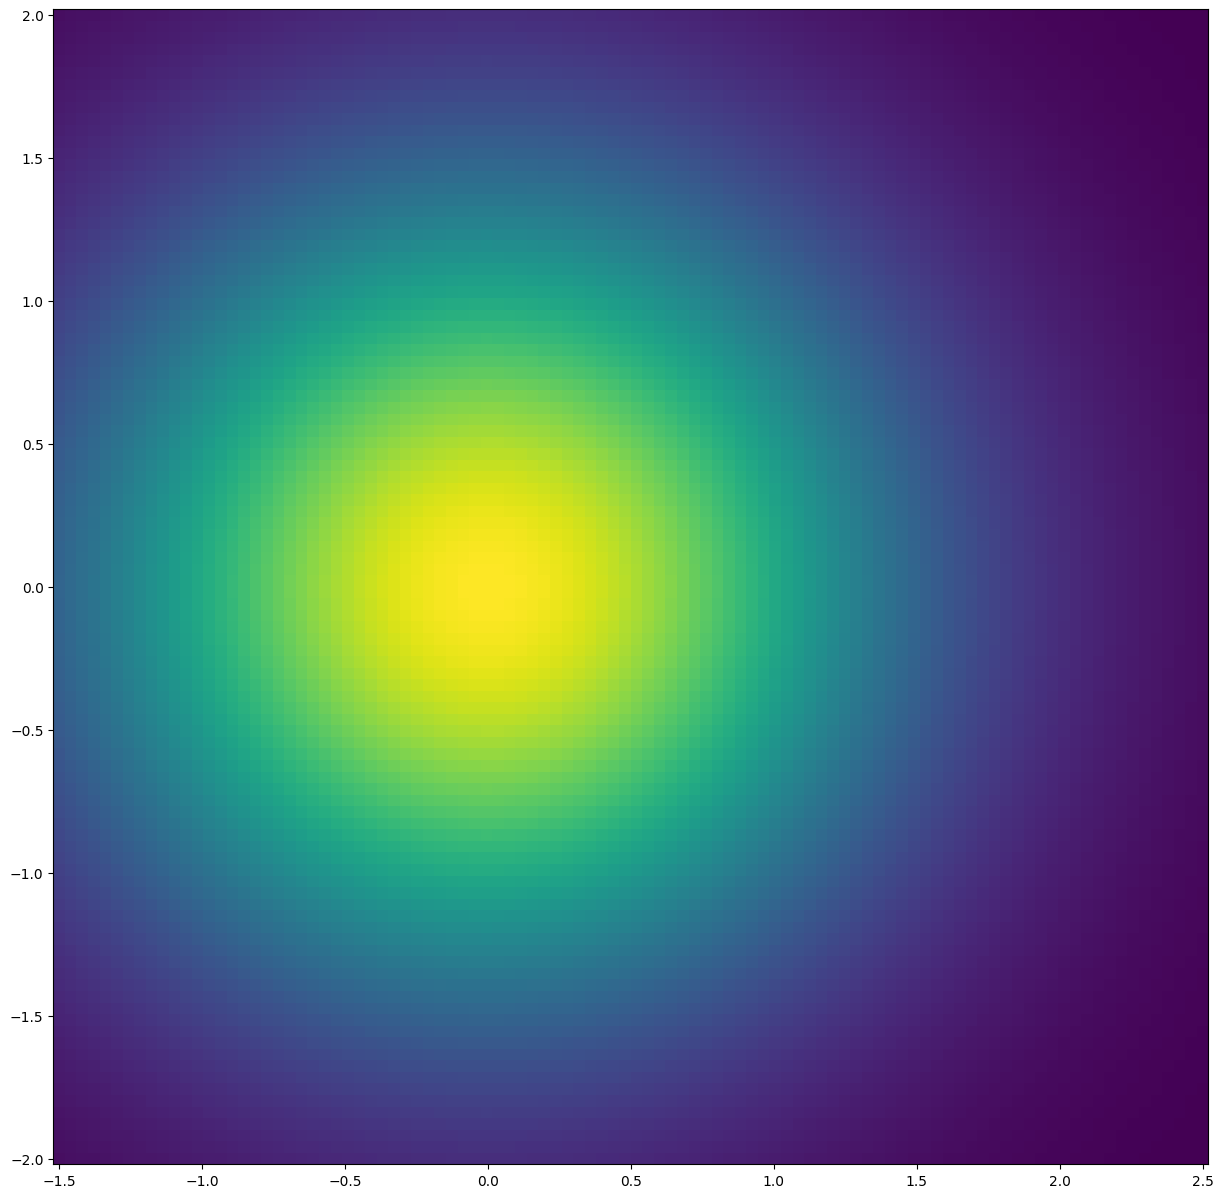

In [3]:
# Plot target distribution
x_np, _ = make_moons(2 ** 20, noise=0.1)
plt.figure(figsize=(15, 15))
plt.hist2d(x_np[:, 0], x_np[:, 1], bins=200)
plt.show()

# Plot initial flow distribution
grid_size = 100
xx, yy = torch.meshgrid(torch.linspace(-1.5, 2.5, grid_size), torch.linspace(-2, 2, grid_size))
zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)
zz = zz.to(device)

nfm.eval()
log_prob = nfm.log_prob(zz).to('cpu').view(*xx.shape)
nfm.train()
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(15, 15))
plt.pcolormesh(xx, yy, prob.data.numpy())
plt.gca().set_aspect('equal', 'box')
plt.show()

  5%|▍         | 499/10000 [00:28<08:59, 17.59it/s]

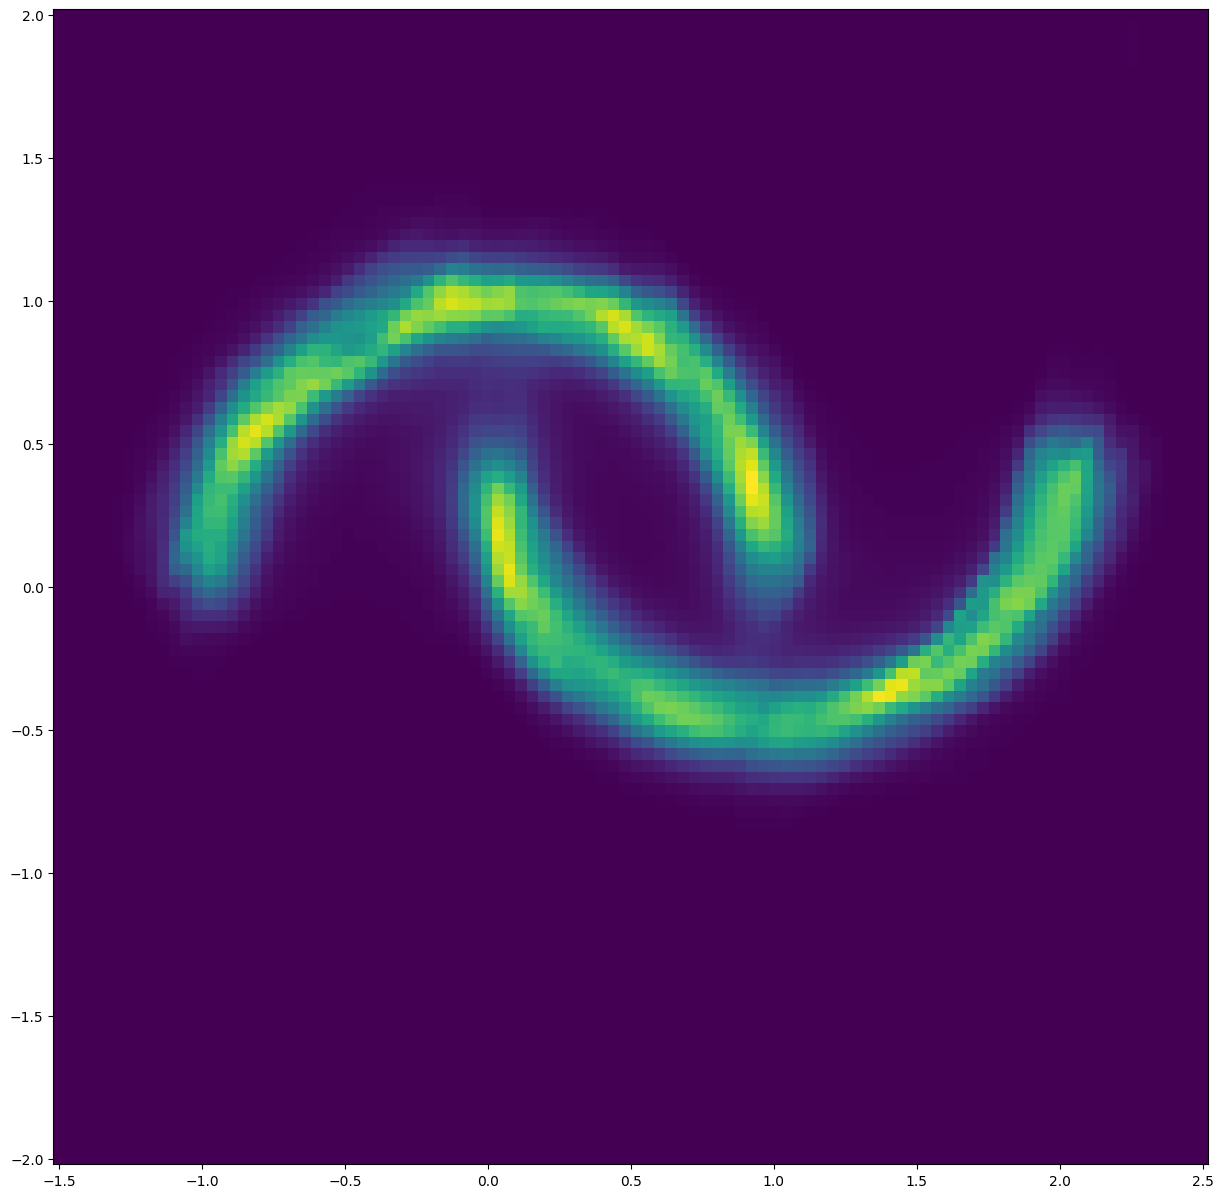

 10%|▉         | 999/10000 [00:57<08:40, 17.30it/s]

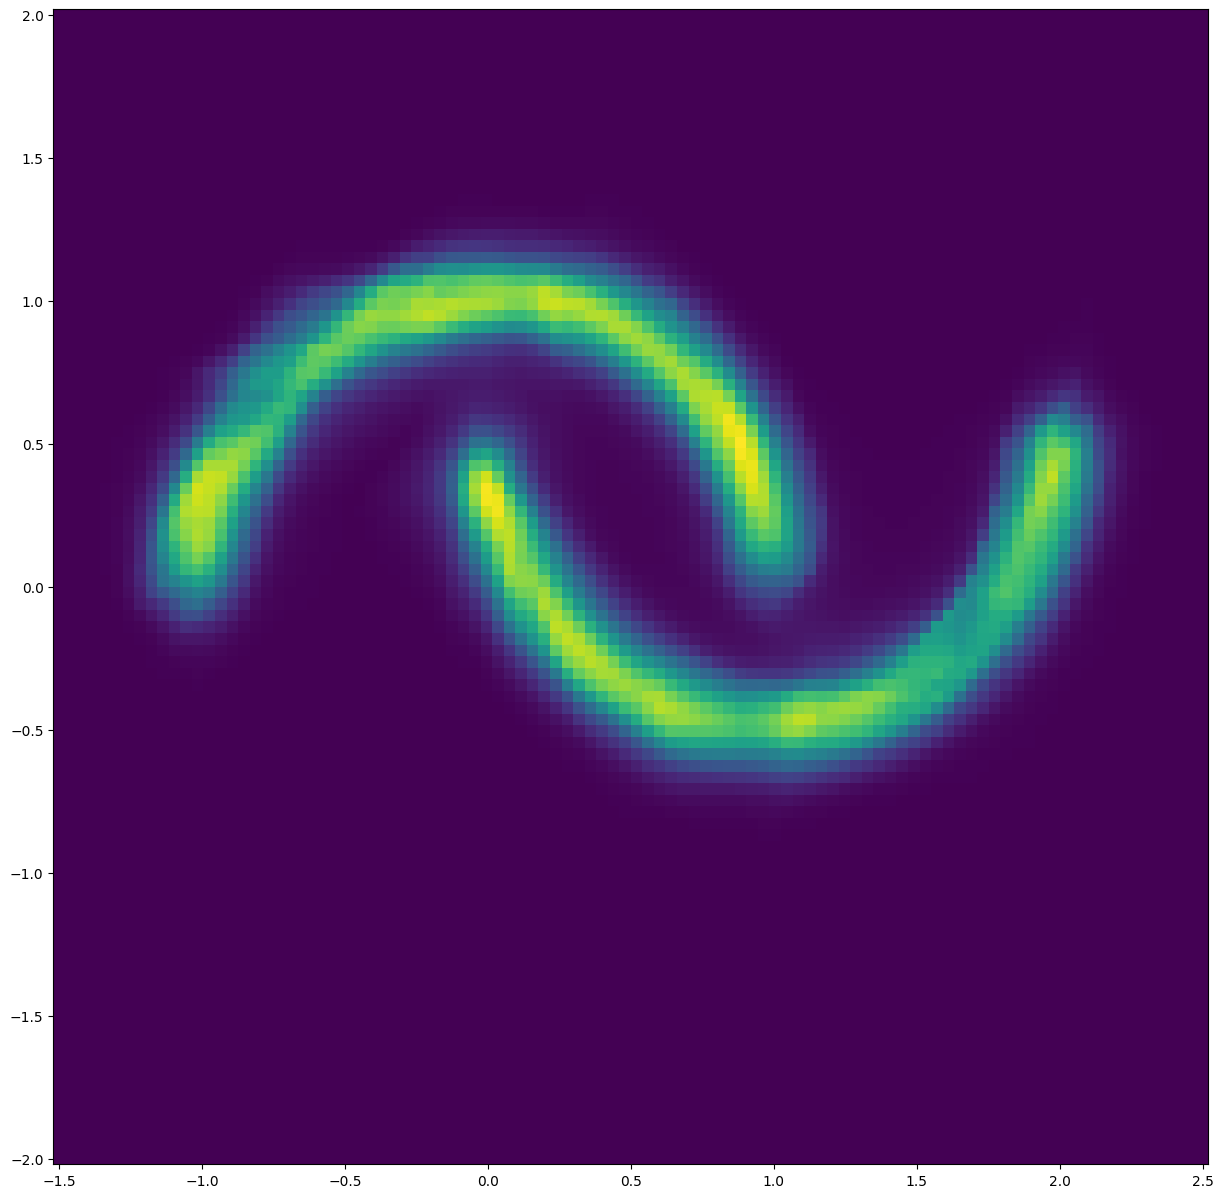

 15%|█▍        | 1499/10000 [01:27<08:15, 17.17it/s]

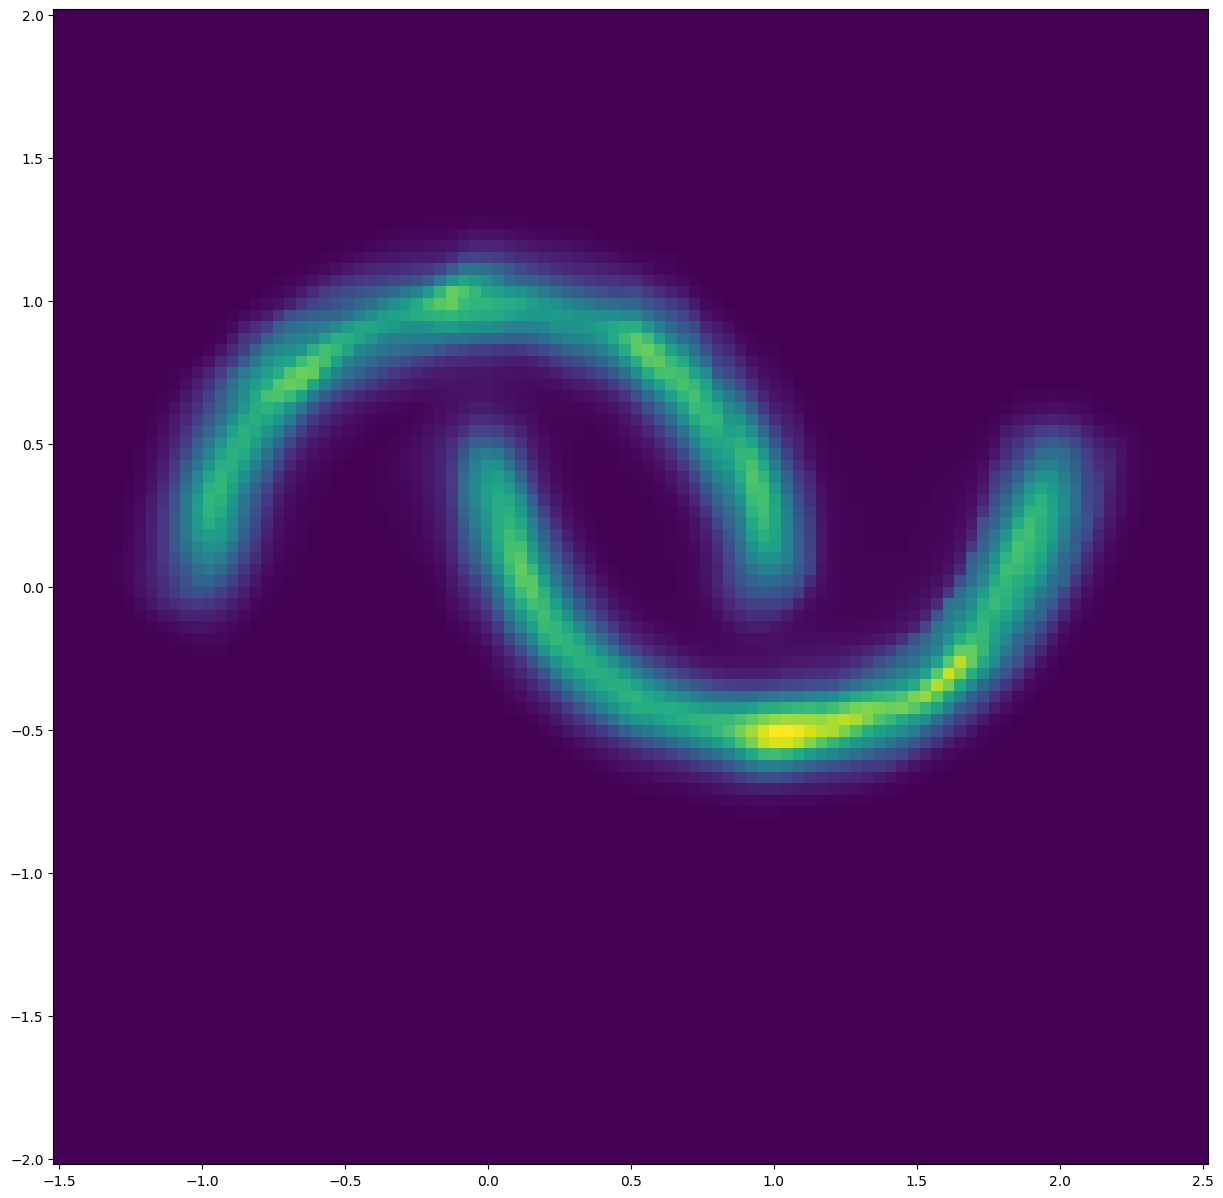

 20%|█▉        | 1999/10000 [01:56<07:31, 17.70it/s]

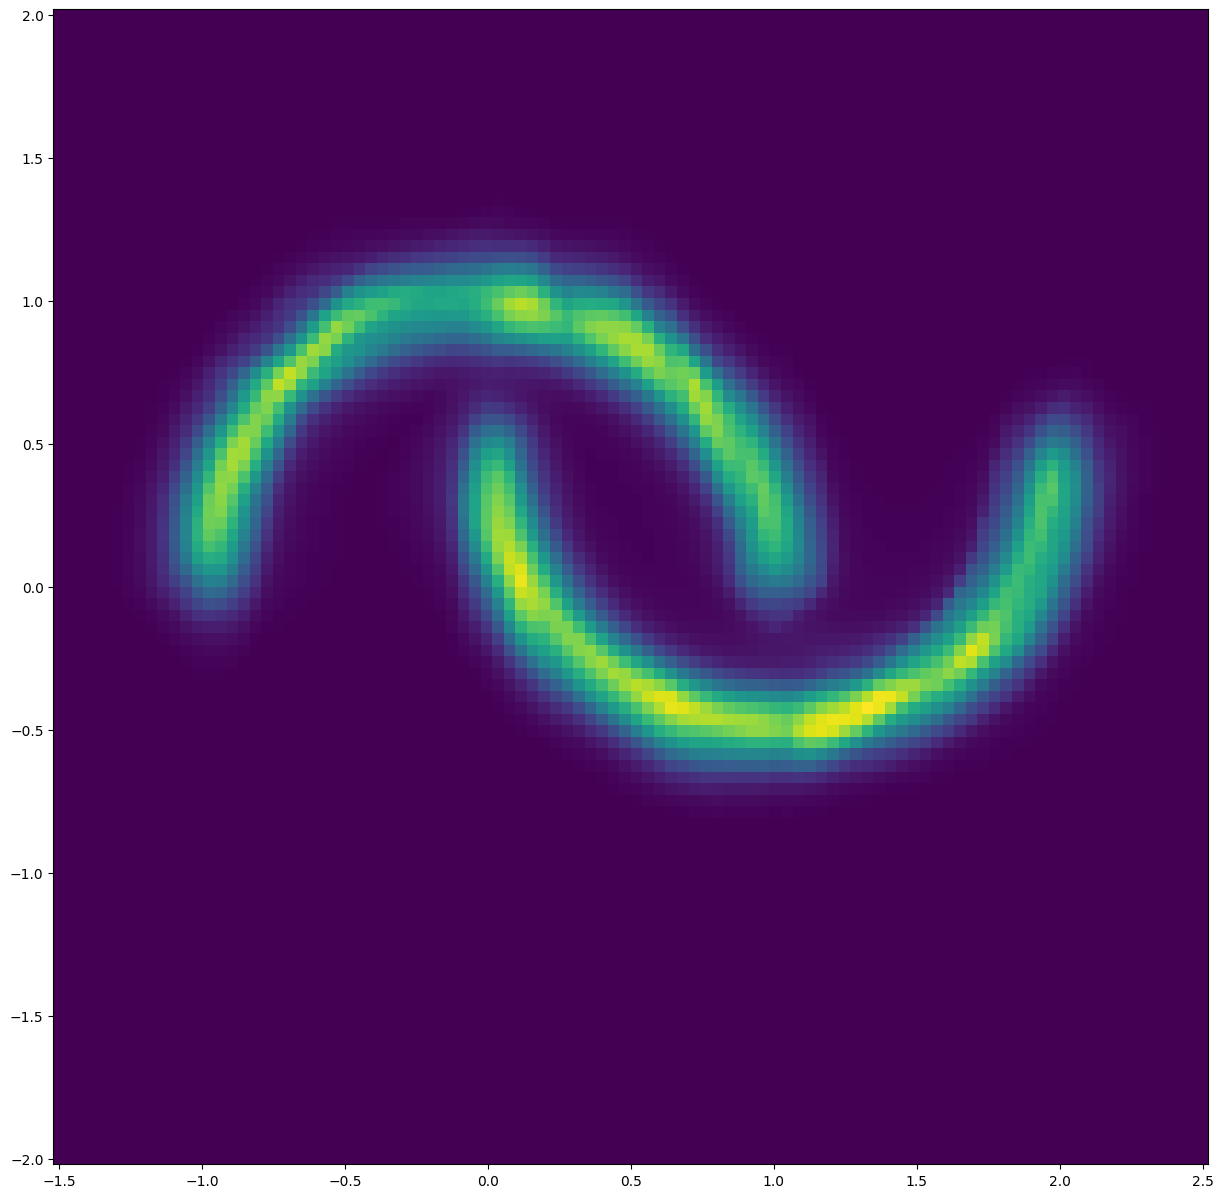

 25%|██▍       | 2499/10000 [02:25<06:59, 17.87it/s]

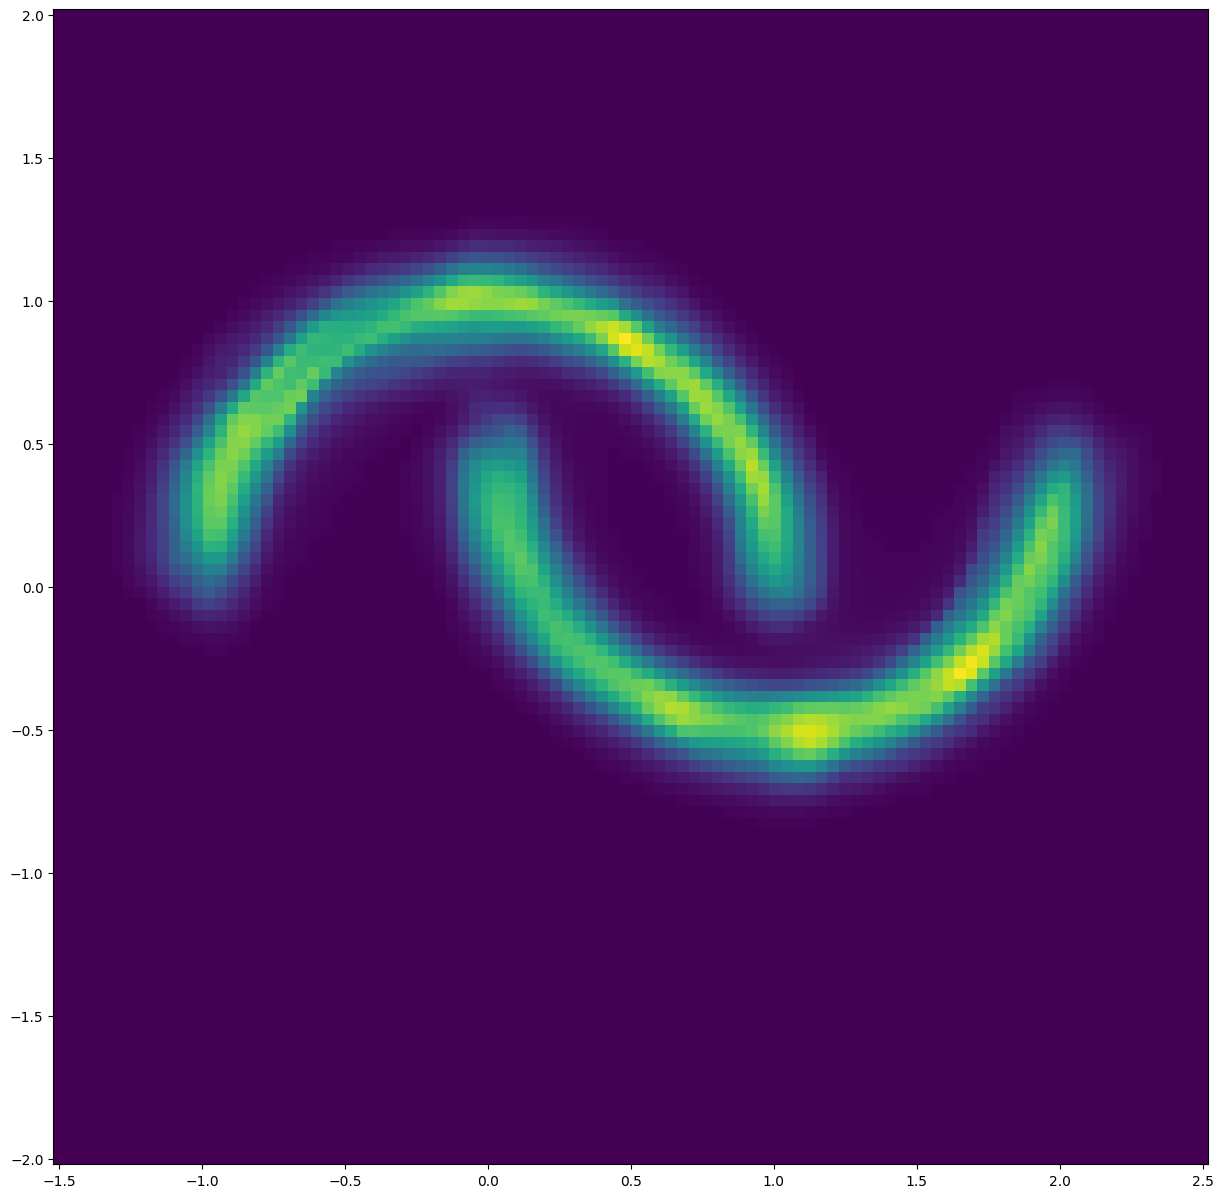

 30%|██▉       | 2999/10000 [02:53<06:32, 17.83it/s]

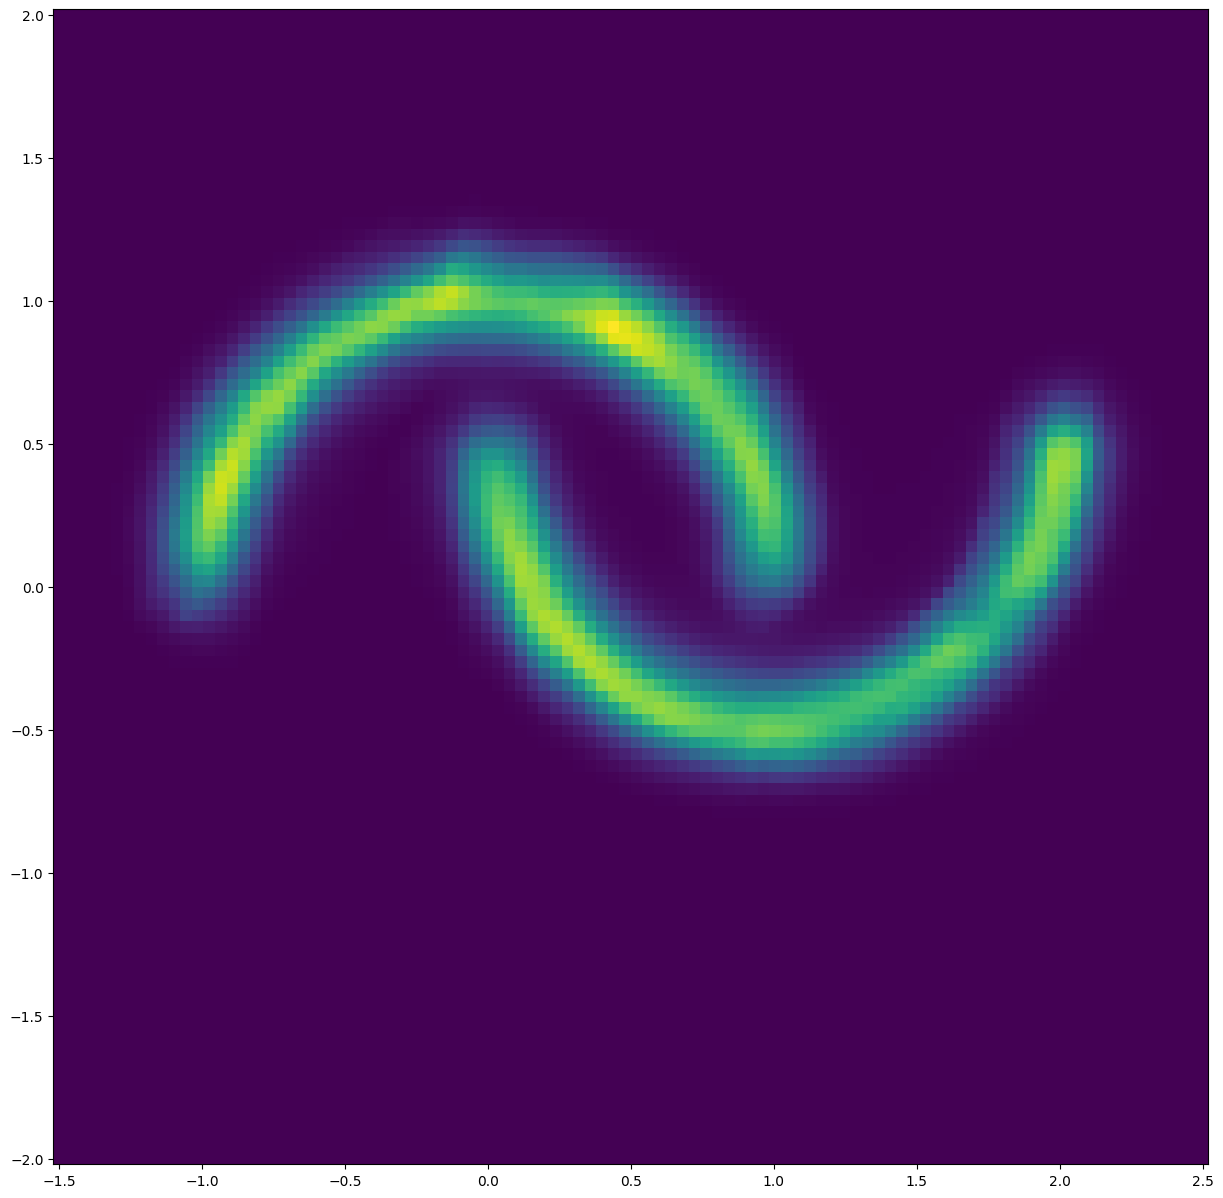

 35%|███▍      | 3499/10000 [03:22<06:04, 17.85it/s]

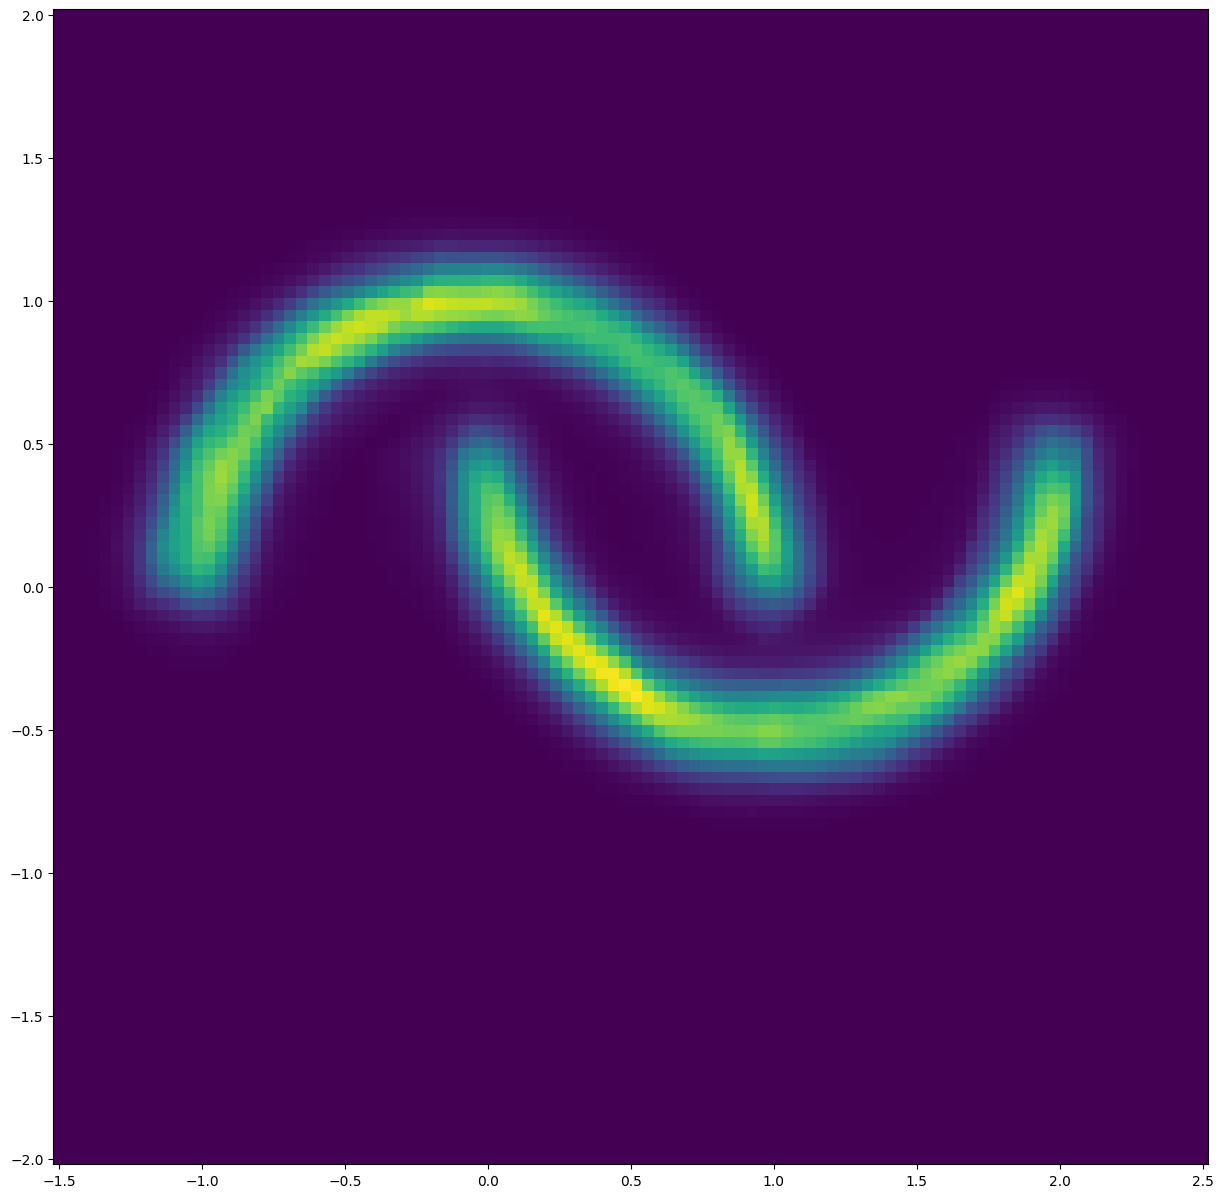

 40%|███▉      | 3999/10000 [03:51<05:43, 17.45it/s]

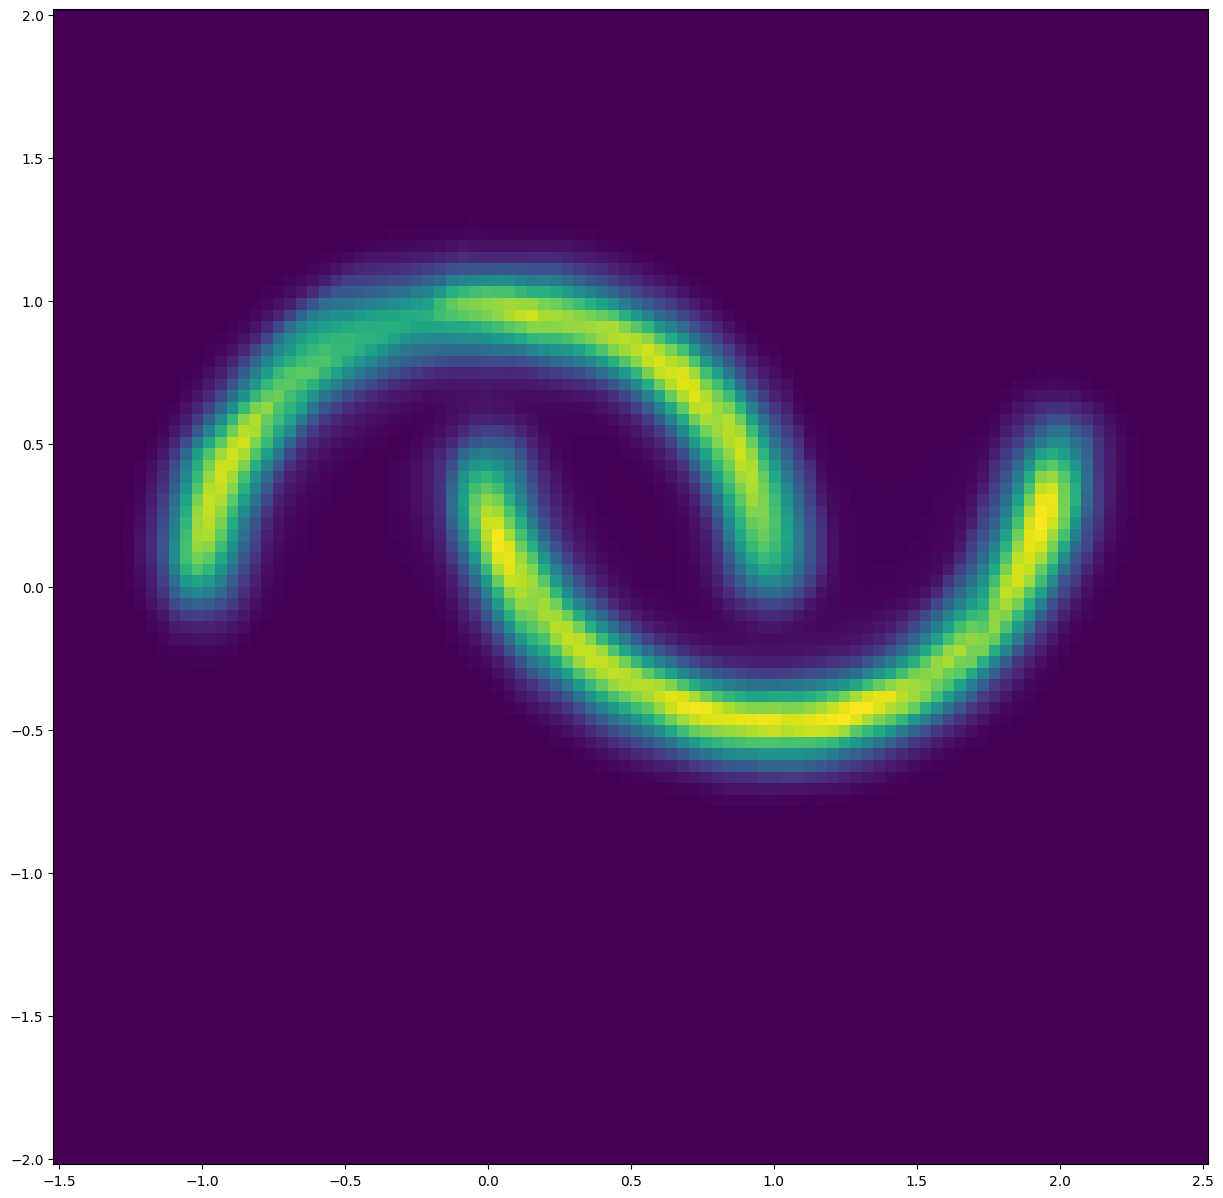

 45%|████▍     | 4499/10000 [04:19<05:05, 17.99it/s]

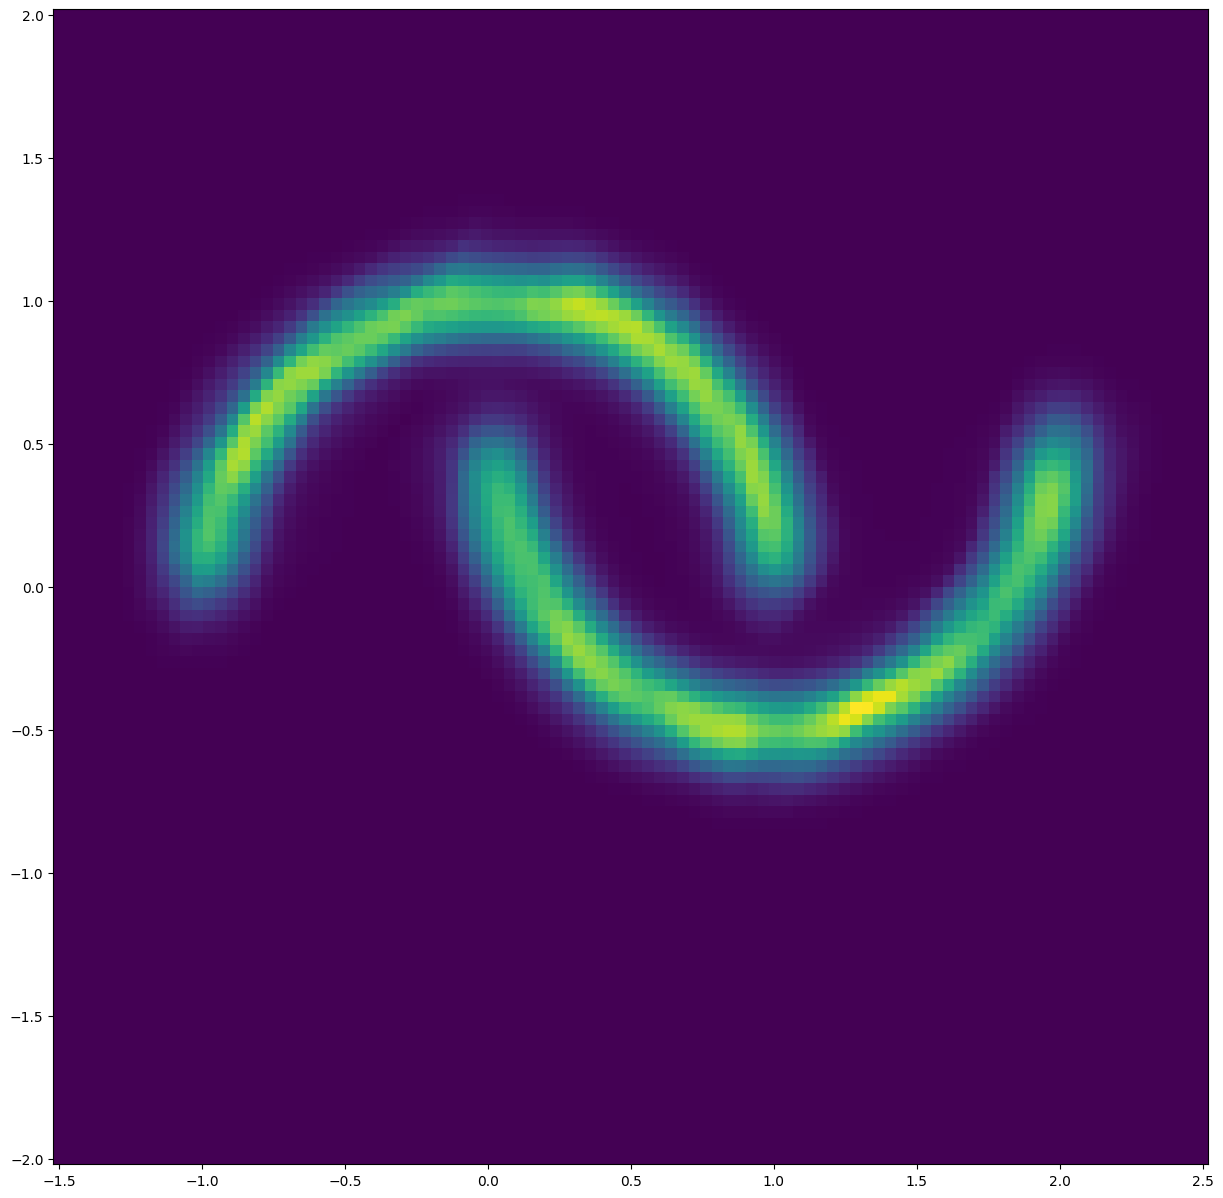

 50%|████▉     | 4999/10000 [04:47<04:38, 17.94it/s]

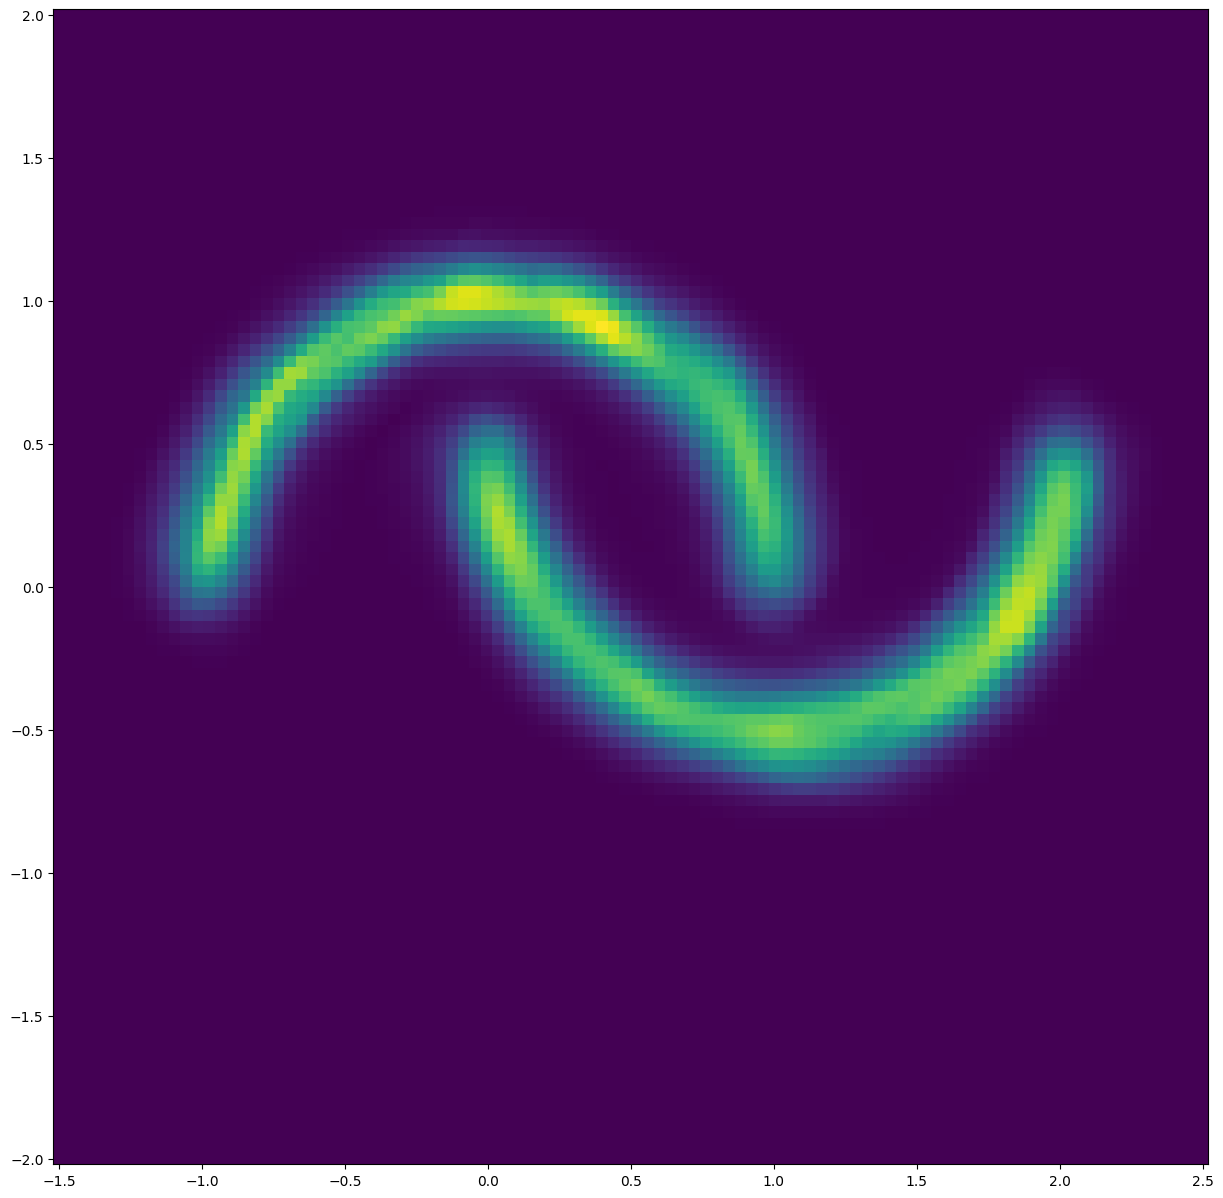

 55%|█████▍    | 5499/10000 [05:16<04:28, 16.76it/s]

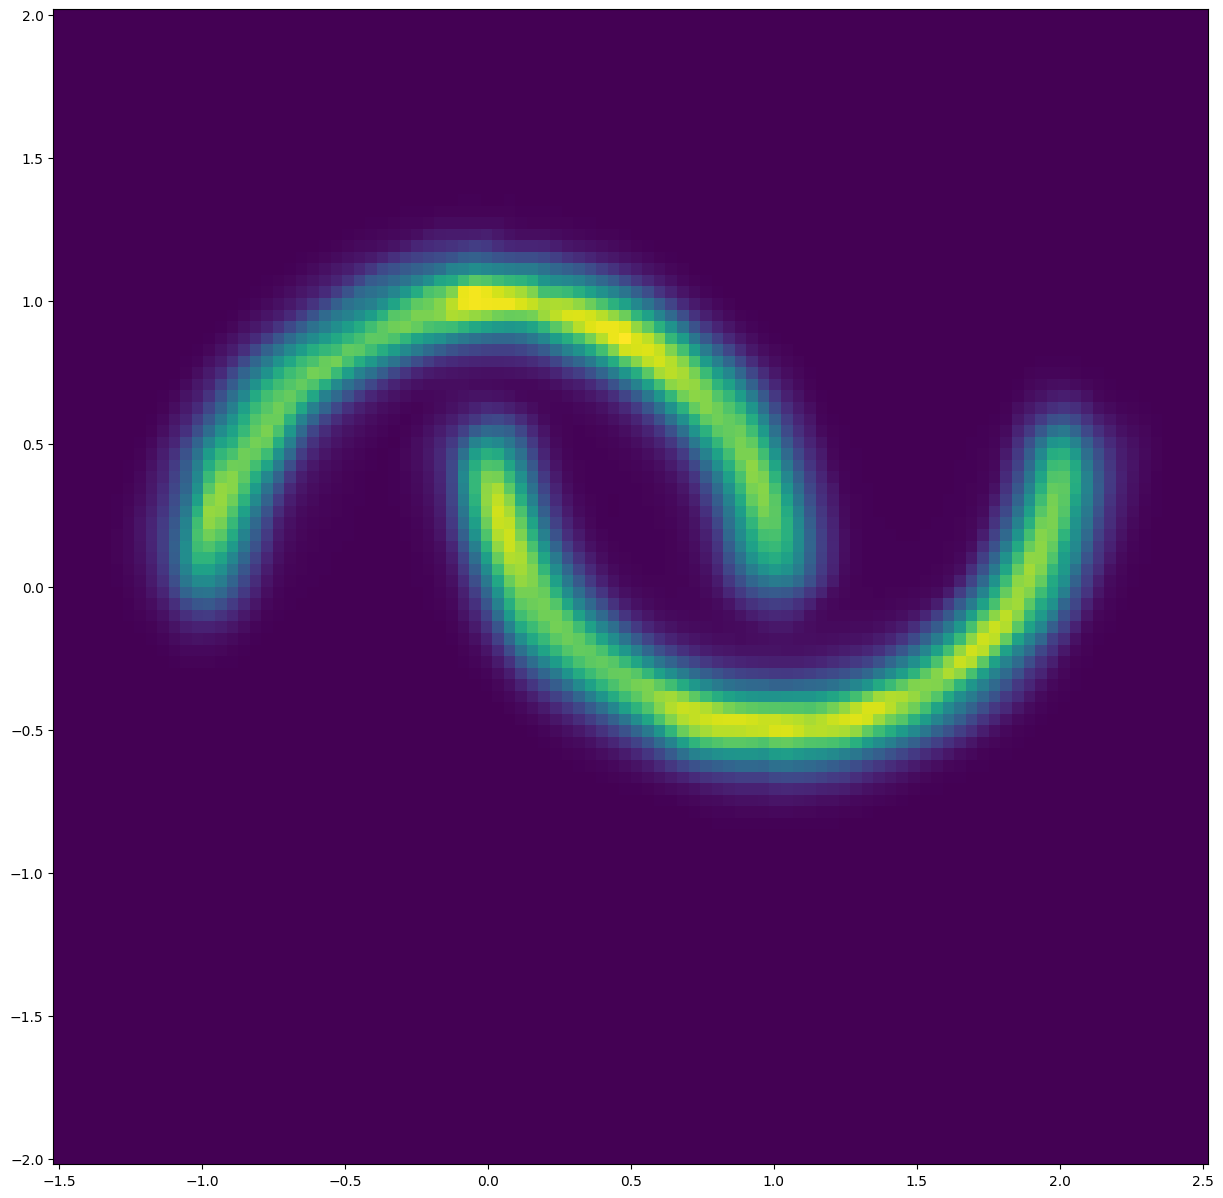

 60%|█████▉    | 5999/10000 [05:45<03:56, 16.90it/s]

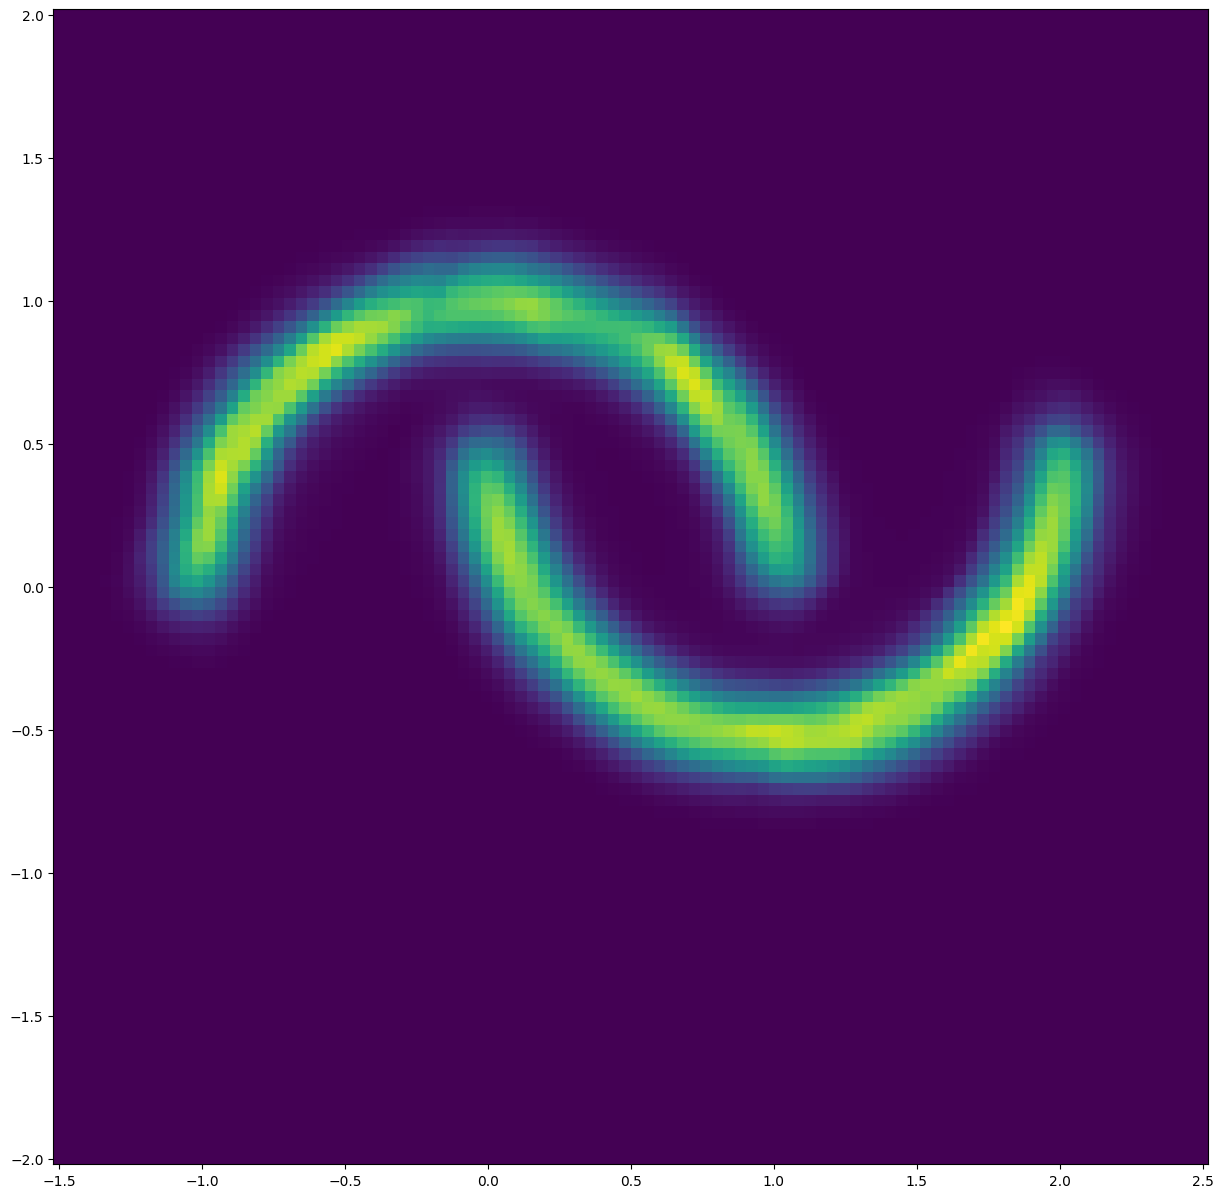

 65%|██████▍   | 6499/10000 [06:14<03:21, 17.33it/s]

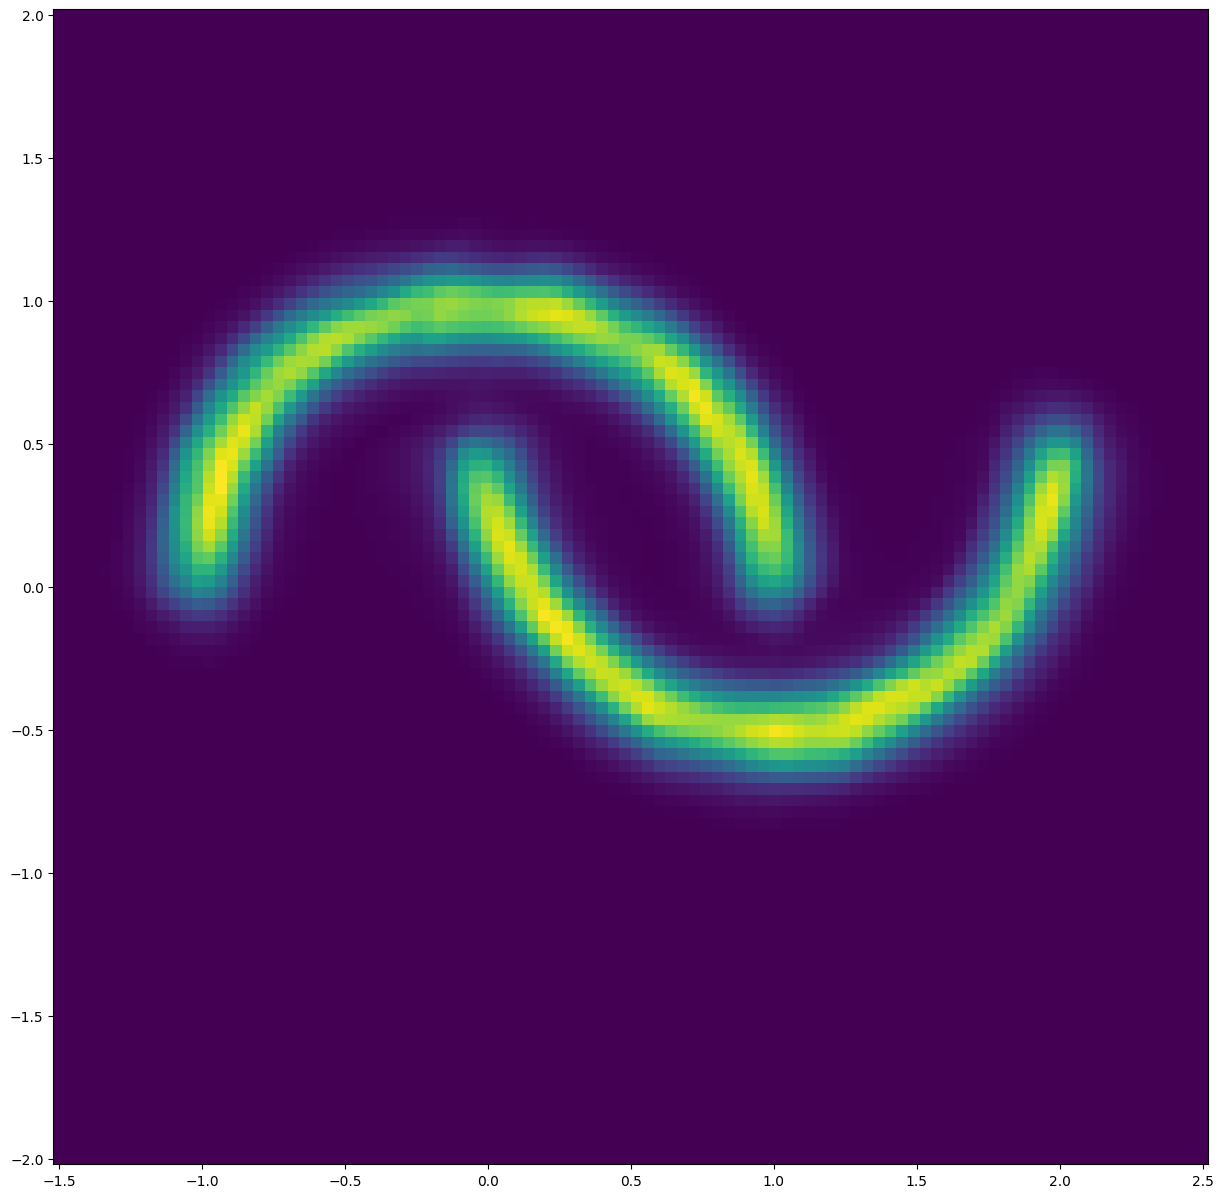

 70%|██████▉   | 6999/10000 [06:44<02:59, 16.73it/s]

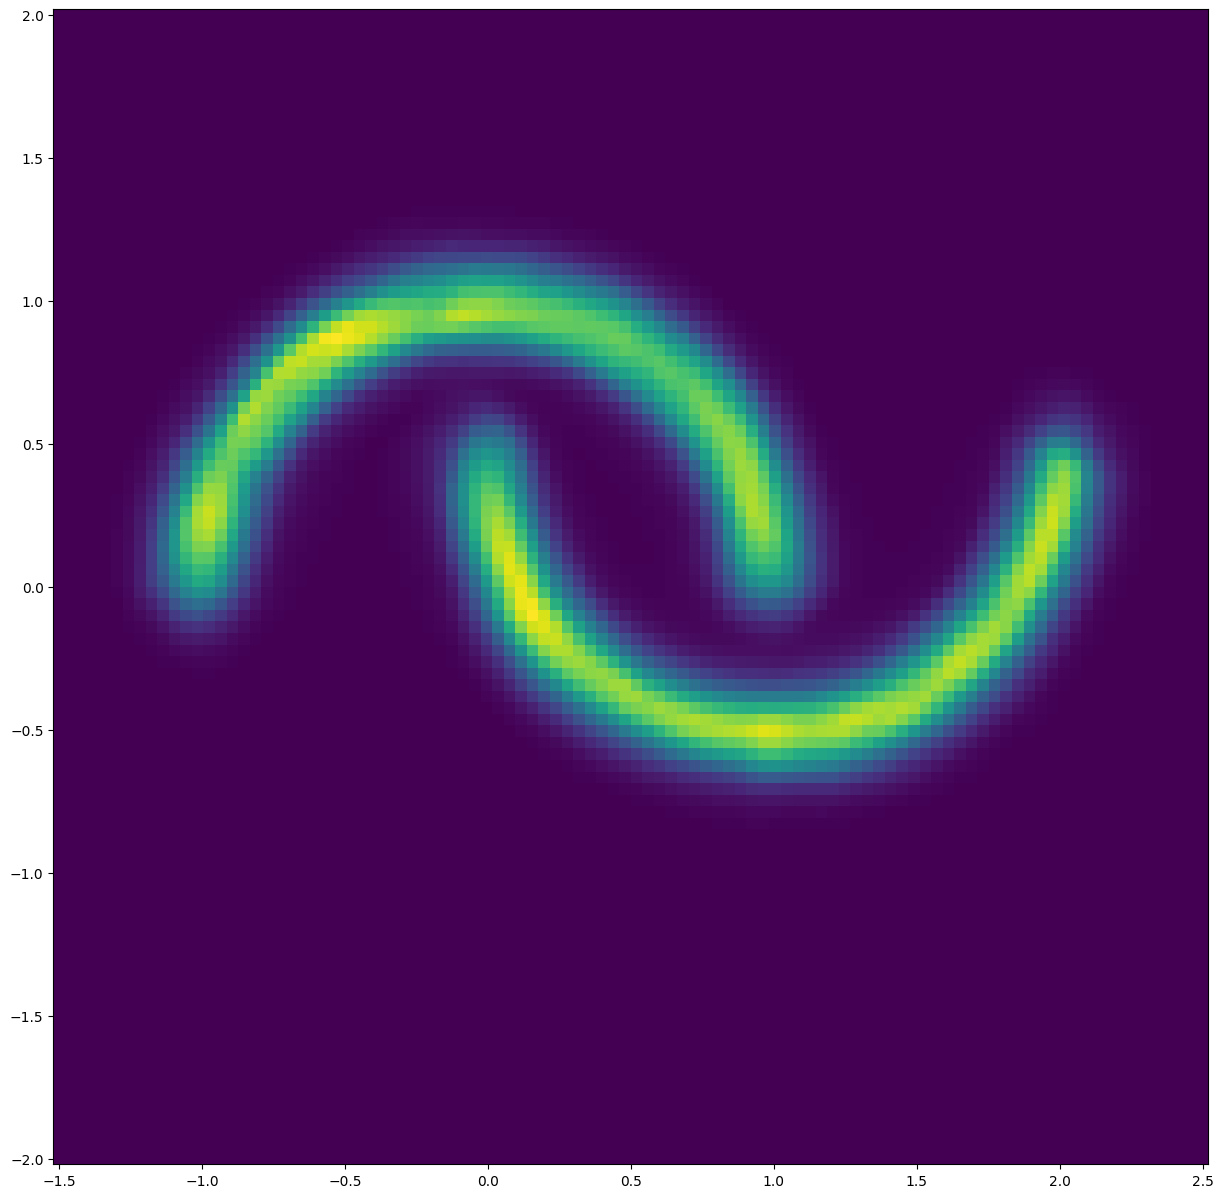

 75%|███████▍  | 7499/10000 [07:14<02:24, 17.27it/s]

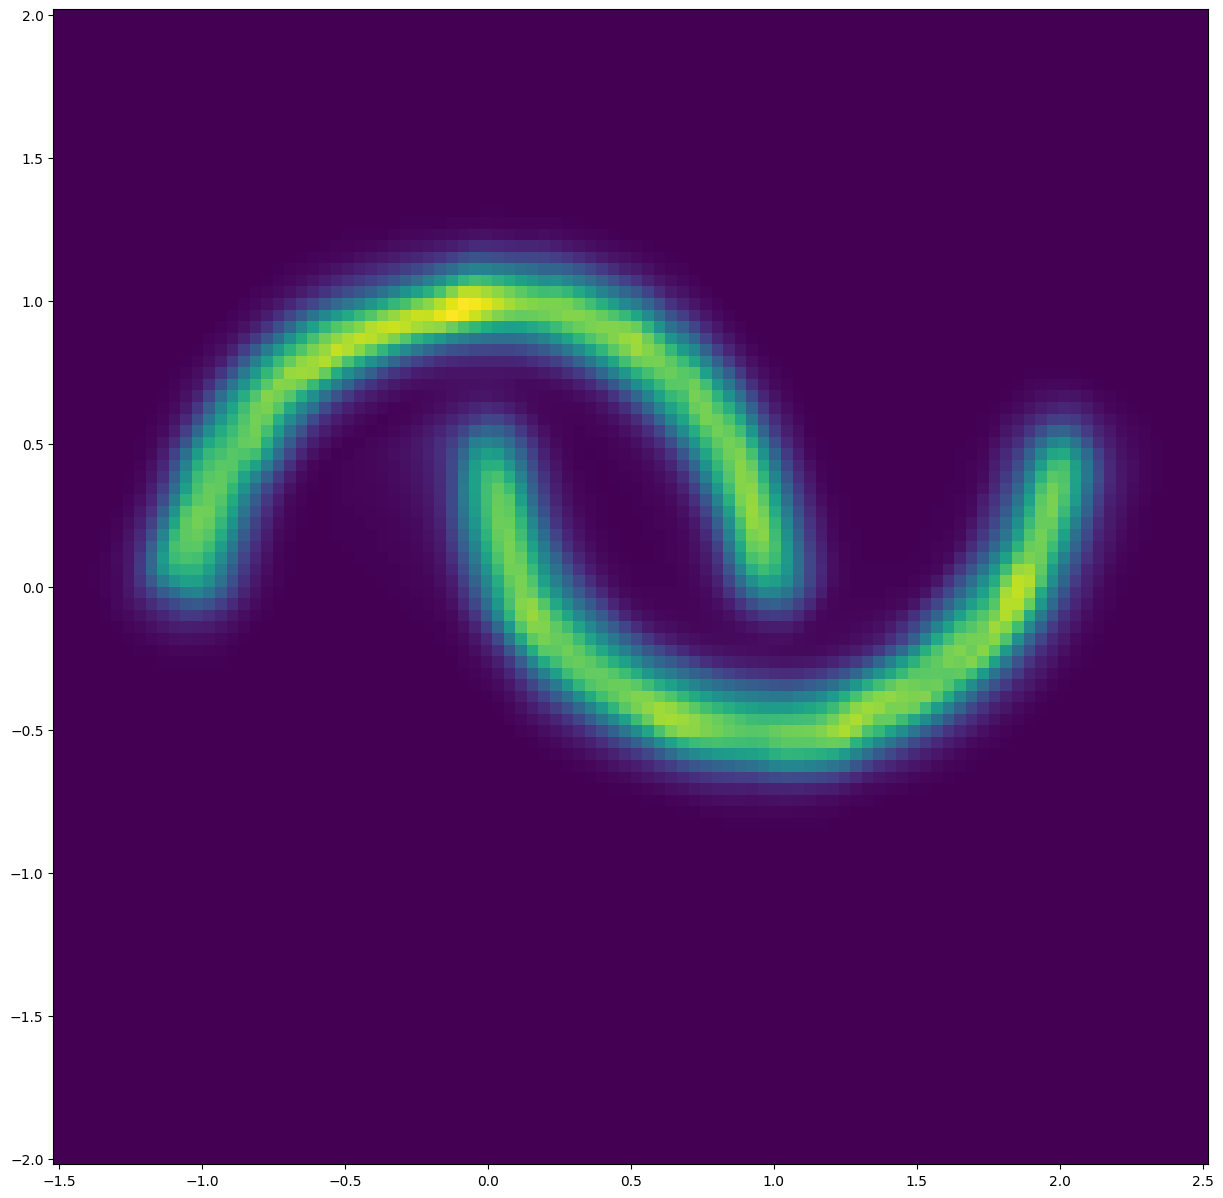

 80%|███████▉  | 7999/10000 [07:44<02:01, 16.49it/s]

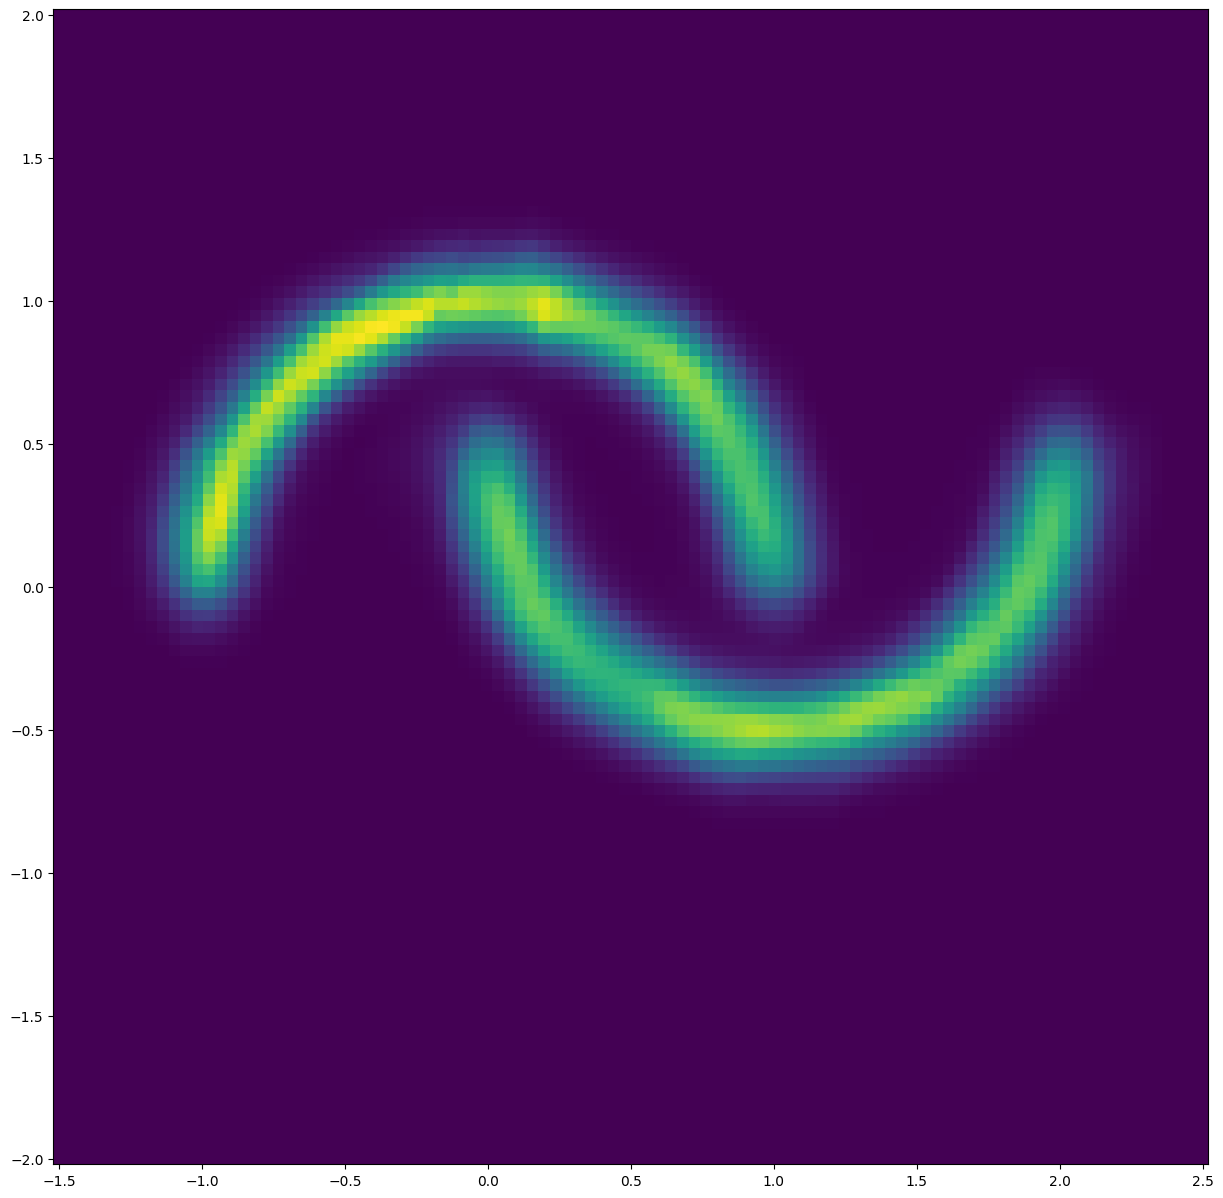

 85%|████████▍ | 8499/10000 [08:14<01:31, 16.39it/s]

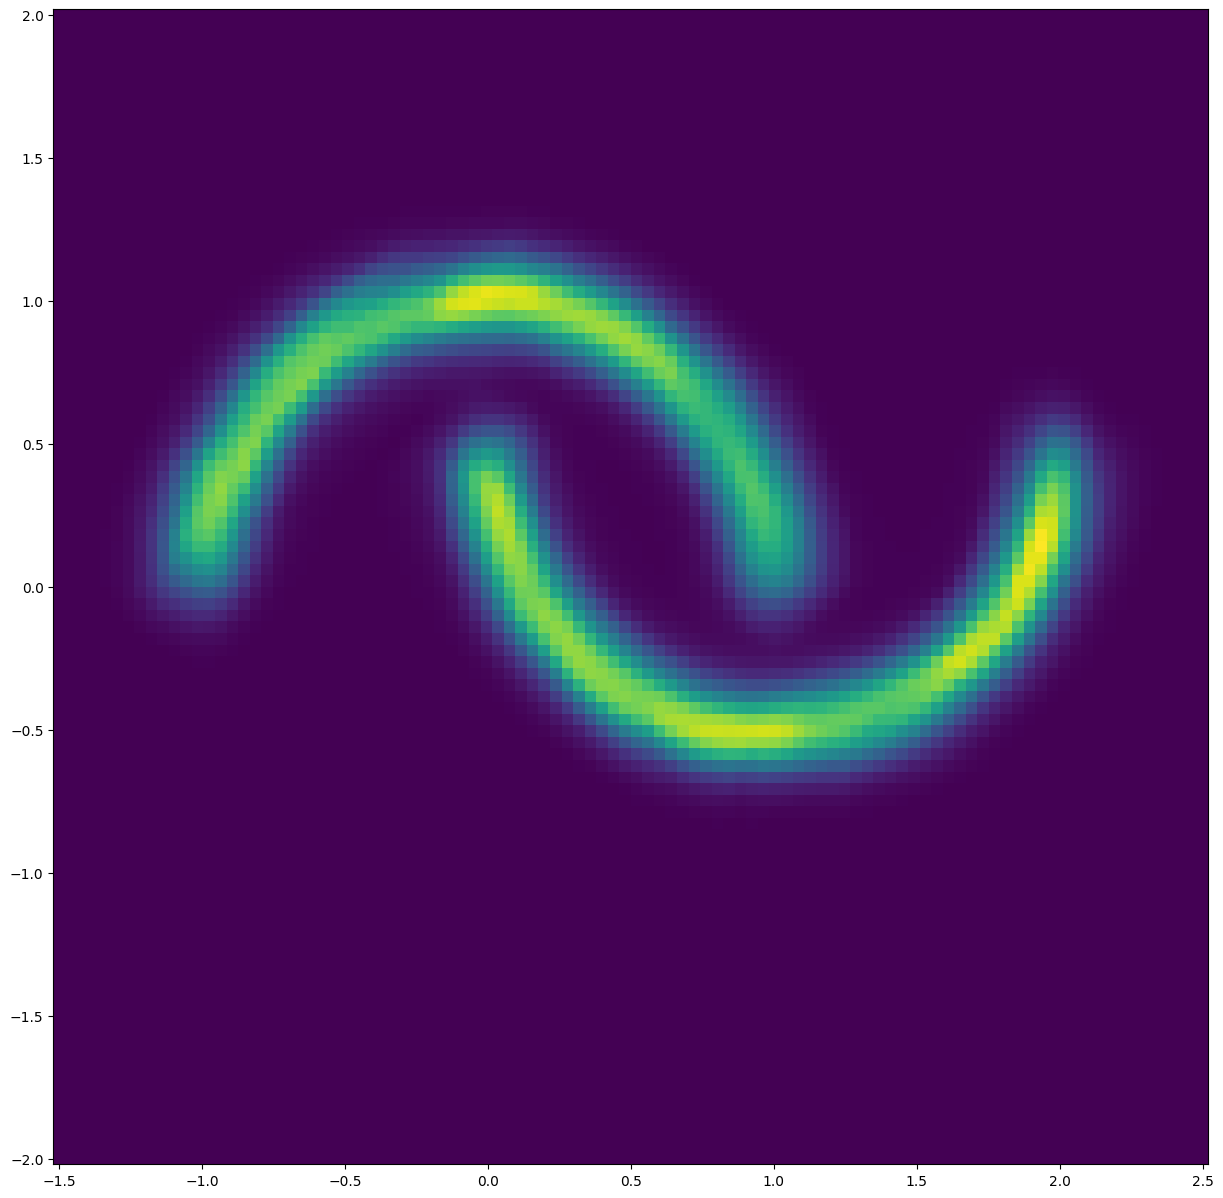

 90%|████████▉ | 8999/10000 [08:43<00:55, 17.93it/s]

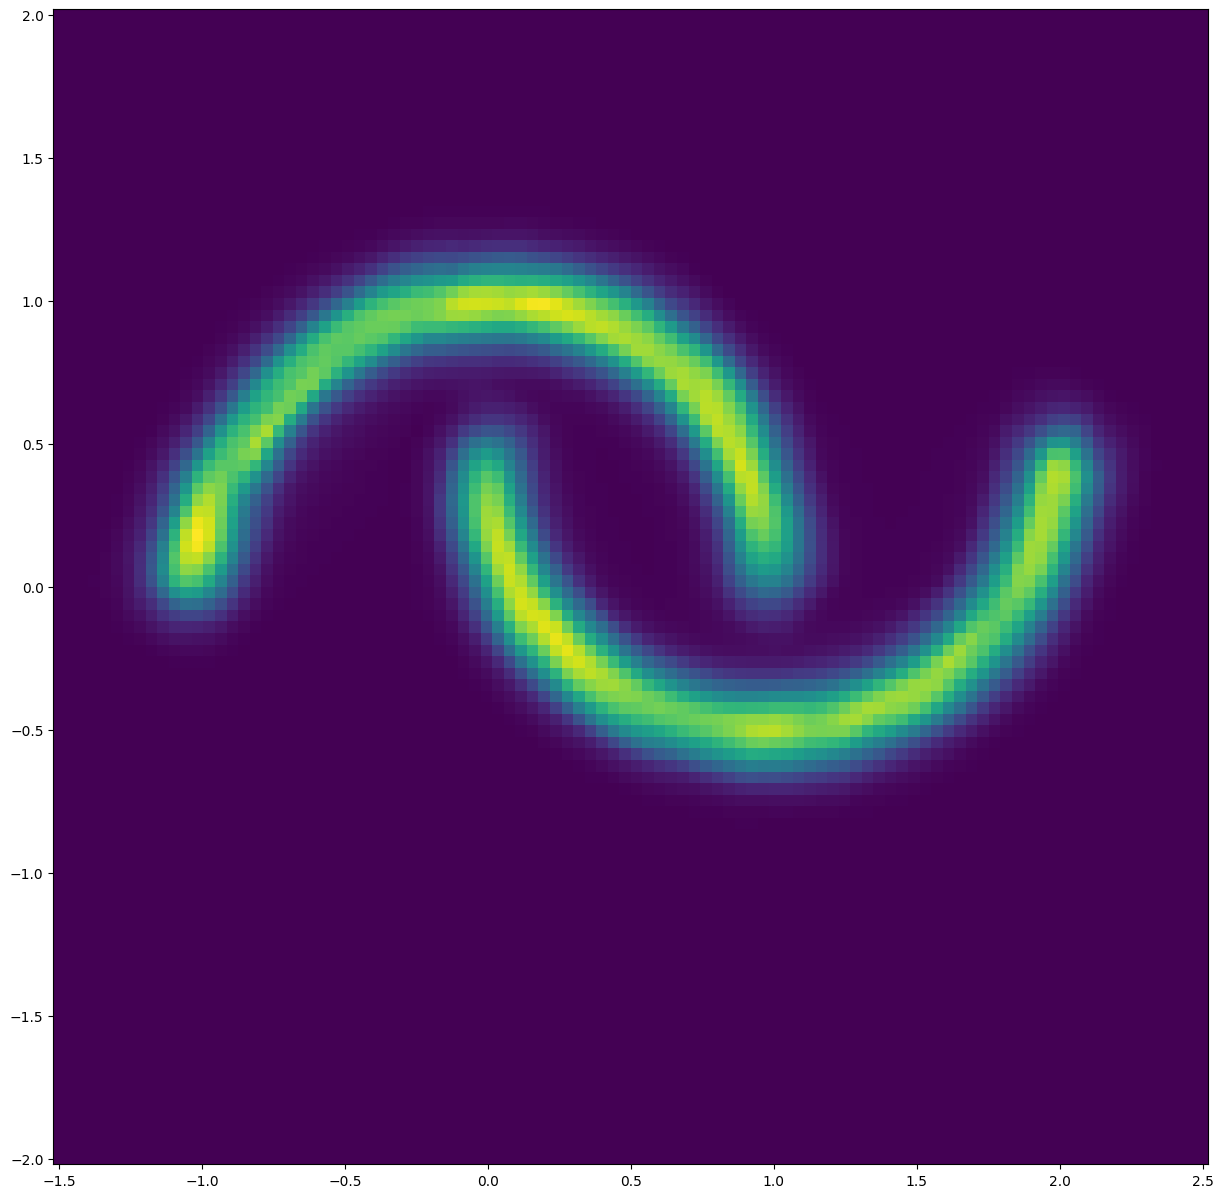

 95%|█████████▍| 9499/10000 [09:11<00:27, 17.90it/s]

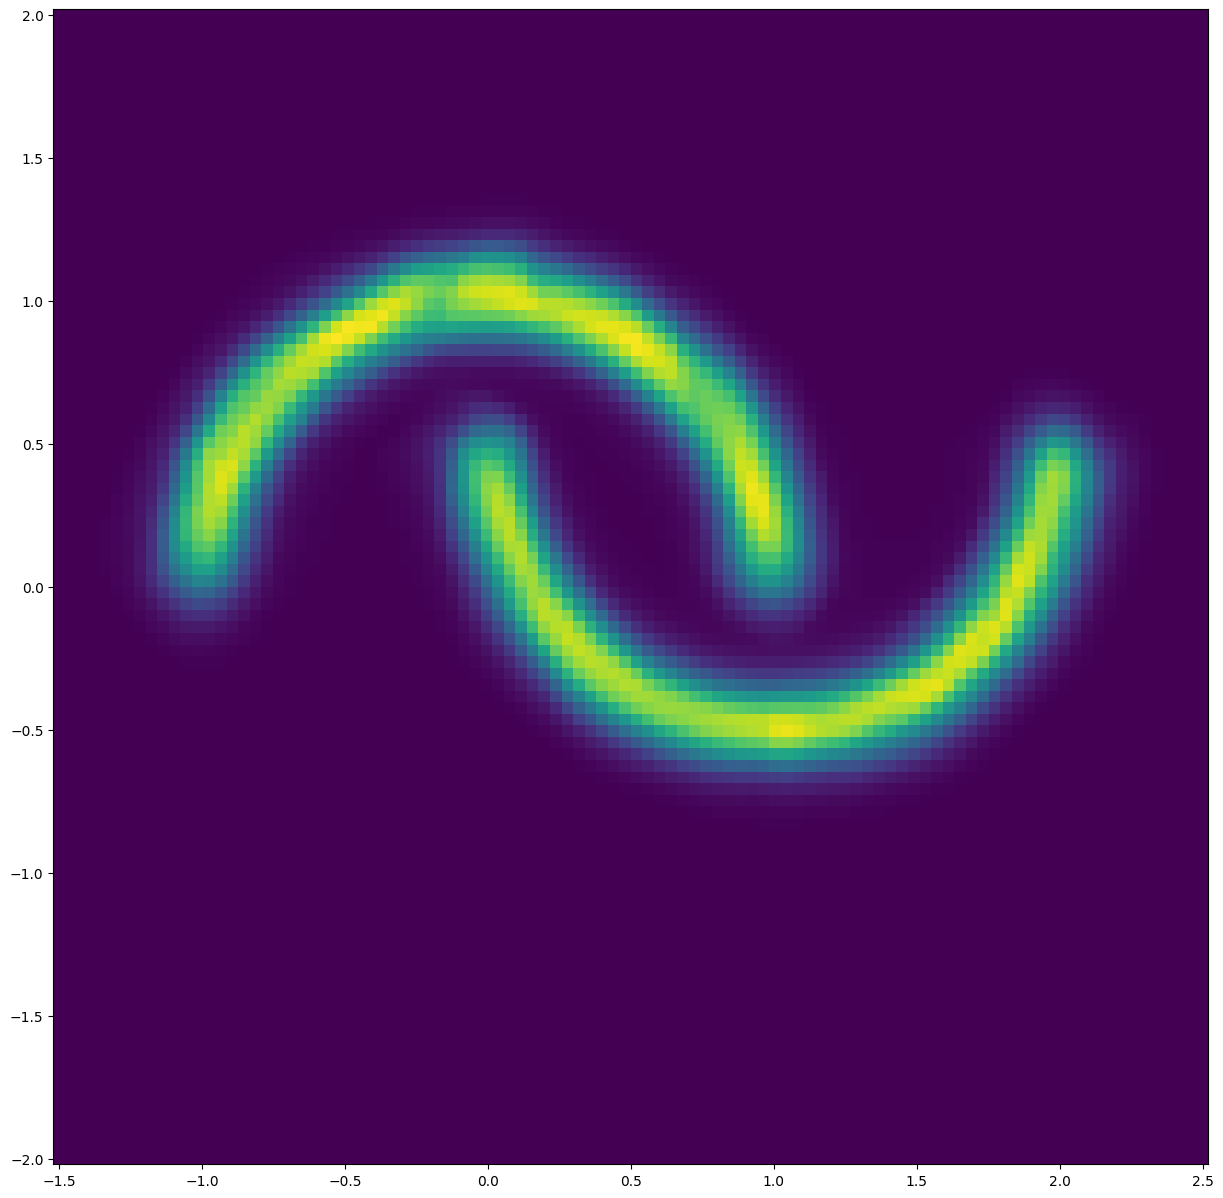

100%|█████████▉| 9999/10000 [09:40<00:00, 17.92it/s]

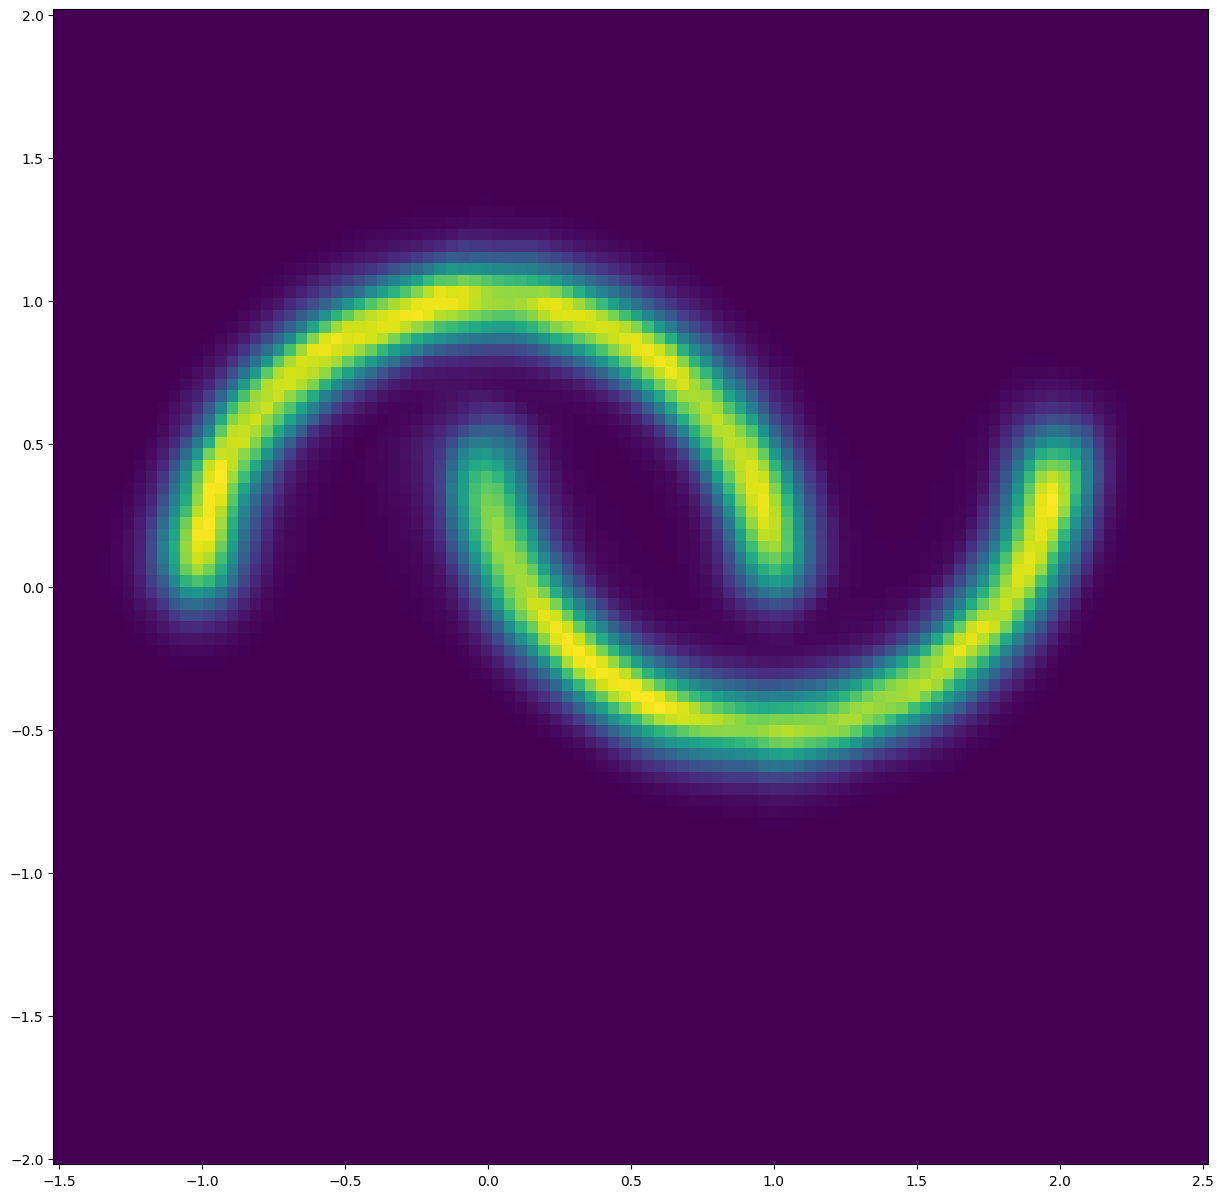

100%|██████████| 10000/10000 [09:40<00:00, 17.23it/s]


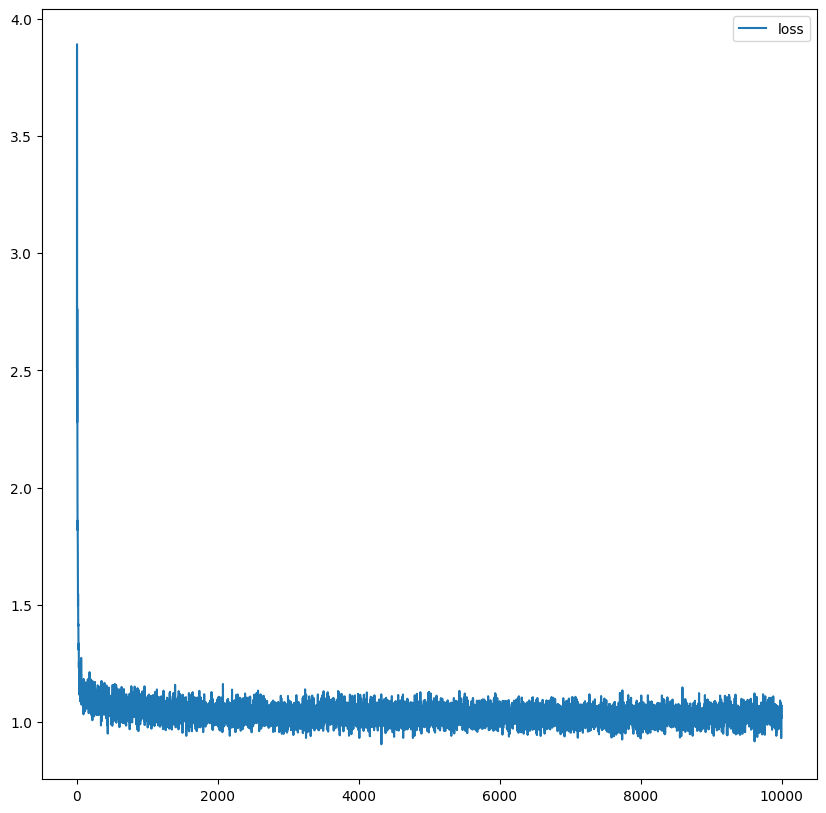

In [4]:
# Train model
max_iter = 10000
num_samples = 2 ** 9
show_iter = 500


loss_hist = np.array([])

optimizer = torch.optim.Adam(nfm.parameters(), lr=1e-3, weight_decay=1e-5)
for it in tqdm(range(max_iter)):
    optimizer.zero_grad()

    # Get training samples
    x_np, _ = make_moons(num_samples, noise=0.1)
    x = torch.tensor(x_np).float().to(device)

    # Compute loss
    loss = nfm.forward_kld(x)

    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer.step()

    # Log loss
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())

    # Plot learned distribution
    if (it + 1) % show_iter == 0:
        nfm.eval()
        log_prob = nfm.log_prob(zz)
        nfm.train()
        prob = torch.exp(log_prob.to('cpu').view(*xx.shape))
        prob[torch.isnan(prob)] = 0

        plt.figure(figsize=(15, 15))
        plt.pcolormesh(xx, yy, prob.data.numpy())
        plt.gca().set_aspect('equal', 'box')
        plt.show()

# Plot loss
plt.figure(figsize=(10, 10))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()